# Comprehensive Exploratory Data Analysis: Step by Step

<a name='1'></a>
## 1 - Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

import os
# import wandb
import warnings

from config import *
from utils.eda_functions import *
from src.data_preprocessing.demographics import *
from src.data_preprocessing.vitals_labs import *
from src.data_preprocessing.split_dataset import *
from src.data_imputation.simple_impute import *
from src.data_imputation.hybrid_impute import hybrid_imputer
from utils.safe_display import blind_display

%load_ext autoreload
%autoreload 2

In [2]:
# Configuration & Settings:

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')
os.environ['WANDB_SILENT'] = 'true'
sns.set_theme(style="whitegrid")

# # Login and initialize a new wandb run
# wandb_key = os.environ.get("WANDB_API_KEY")
# ! wandb login $wandb_key
#
# run = wandb.init(
#     project='FuzzyMedNet',
#     name='patient_eda',
#     job_type='eda'
# )

In [3]:
# Safety flag - when set to True will not display sensitive data
BLINDED = False

<a name='2'></a>
## 2 - Data Overview

<a name='2-1'></a>
### 2.1 - Loading the Data

In [4]:
# Open the file in read mode
with h5py.File(DATA_FILE_PATH, 'r') as file:
    # Print the keys at the root of the file
    print(list(file.keys()))

patients = pd.read_hdf(DATA_FILE_PATH, 'patients')
vitals_labs = pd.read_hdf(DATA_FILE_PATH, 'vitals_labs')
vitals_labs_mean = pd.read_hdf(DATA_FILE_PATH, 'vitals_labs_mean')
interventions = pd.read_hdf(DATA_FILE_PATH, 'interventions')
codes = pd.read_hdf(DATA_FILE_PATH, 'codes')

['codes', 'interventions', 'patients', 'vitals_labs', 'vitals_labs_mean']


<a name='2-2'></a>
### 2.2 - Basic Information

In [5]:
print(f'patients.shape: {patients.shape}')
print(patients.info())

patients.shape: (34472, 28)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34472 entries, (3, 145834, 211552) to (99999, 113369, 246512)
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   gender                  34472 non-null  category      
 1   ethnicity               34472 non-null  category      
 2   age                     34472 non-null  float64       
 3   insurance               34472 non-null  object        
 4   admittime               34472 non-null  datetime64[ns]
 5   diagnosis_at_admission  34471 non-null  object        
 6   dischtime               34472 non-null  datetime64[ns]
 7   discharge_location      34472 non-null  object        
 8   fullcode_first          28162 non-null  float64       
 9   dnr_first               28162 non-null  float64       
 10  fullcode                28162 non-null  float64       
 11  dnr                     28162 non-null  fl

In [6]:
print(f'vitals_labs_mean.shape: {vitals_labs_mean.shape}')
print(vitals_labs_mean.info())

vitals_labs_mean.shape: (2200954, 104)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200954 entries, (3, 145834, 211552, 0) to (99999, 113369, 246512, 26)
Columns: 104 entries, ('alanine aminotransferase', 'mean') to ('ph urine', 'mean')
dtypes: float64(104)
memory usage: 1.7 GB
None


In [7]:
print(f'interventions.shape: {interventions.shape}')
print(interventions.info())

interventions.shape: (2200954, 14)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200954 entries, (3, 145834, 211552, 0) to (99999, 113369, 246512, 26)
Data columns (total 14 columns):
 #   Column             Dtype
---  ------             -----
 0   vent               int64
 1   vaso               int64
 2   adenosine          int64
 3   dobutamine         int64
 4   dopamine           int64
 5   epinephrine        int64
 6   isuprel            int64
 7   milrinone          int64
 8   norepinephrine     int64
 9   phenylephrine      int64
 10  vasopressin        int64
 11  colloid_bolus      int64
 12  crystalloid_bolus  int64
 13  nivdurations       int64
dtypes: int64(14)
memory usage: 269.0 MB
None


In [8]:
# Limit vital signs, lab measurements, and interventions to the first 30 hours of admission
vitals_labs = vitals_labs[vitals_labs.index.get_level_values('hours_in') < 30]
vitals_labs_mean = vitals_labs_mean[vitals_labs_mean.index.get_level_values('hours_in') < 30]
interventions = interventions[interventions.index.get_level_values('hours_in') < 30]
blind_display(patients, vitals_labs_mean, interventions, blinded=BLINDED)

patients.shape:  (34472, 28)


,,,gender,ethnicity,age,insurance,admittime,diagnosis_at_admission,dischtime,discharge_location,fullcode_first,dnr_first,...,outtime,los_icu,admission_type,first_careunit,mort_icu,mort_hosp,hospital_expire_flag,hospstay_seq,readmission_30,max_hours
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
3,145834,211552,M,WHITE,76.526792,Medicare,2101-10-20 19:08:00,HYPOTENSION,2101-10-31 13:58:00,SNF,1.0,0.0,...,2101-10-26 20:43:09,6.064560,EMERGENCY,MICU,0,0,0,1,0,145
4,185777,294638,F,WHITE,47.845047,Private,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-23 18:41:00,HOME WITH HOME IV PROVIDR,1.0,0.0,...,2191-03-17 16:46:31,1.678472,EMERGENCY,MICU,0,0,0,1,0,40
6,107064,228232,F,WHITE,65.942297,Medicare,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,2175-06-15 16:00:00,HOME HEALTH CARE,1.0,0.0,...,2175-06-03 13:39:54,3.672917,ELECTIVE,SICU,0,0,0,1,0,88
9,150750,220597,M,UNKNOWN/NOT SPECIFIED,41.790228,Medicaid,2149-11-09 13:06:00,HEMORRHAGIC CVA,2149-11-14 10:15:00,DEAD/EXPIRED,1.0,0.0,...,2149-11-14 20:52:14,5.323056,EMERGENCY,MICU,1,1,1,1,0,127
11,194540,229441,F,WHITE,50.148295,Private,2178-04-16 06:18:00,BRAIN MASS,2178-05-11 19:00:00,HOME HEALTH CARE,1.0,0.0,...,2178-04-17 20:21:05,1.584410,EMERGENCY,SICU,0,0,0,1,0,38


vitals_labs_mean.shape:  (971296, 104)


LEVEL2                                 alanine aminotransferase albumin  \
Aggregation Function                                       mean    mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                            25.0     1.8   
                              1                             NaN     NaN   
                              2                             NaN     NaN   
                              3                             NaN     NaN   
                              4                             NaN     NaN   

LEVEL2                                 albumin ascites albumin pleural  \
Aggregation Function                              mean            mean   
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                    NaN             NaN   
                              1                    NaN             NaN   
                              2                    NaN             NaN   
                              3                    NaN             NaN   
                              4                    NaN             NaN   

LEVEL2                                 albumin urine alkaline phosphate  \
Aggregation Function                            mean               mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                  NaN               73.0   
                              1                  NaN                NaN   
                              2                  NaN                NaN   
                              3                  NaN                NaN   
                              4                  NaN                NaN   

LEVEL2                                  anion gap asparate aminotransferase  \
Aggregation Function                         mean                      mean   
subject_id hadm_id icustay_id hours_in                                        
3          145834  211552     0         20.666667                      69.0   
                              1               NaN                       NaN   
                              2               NaN                       NaN   
                              3               NaN                       NaN   
                              4               NaN                       NaN   

LEVEL2                                 basophils bicarbonate  ...  \
Aggregation Function                        mean        mean  ...   
subject_id hadm_id icustay_id hours_in                        ...   
3          145834  211552     0              NaN   16.333333  ...   
                              1              NaN         NaN  ...   
                              2              NaN         NaN  ...   
                              3              NaN         NaN  ...   
                              4              NaN         NaN  ...   

LEVEL2                                 total protein total protein urine  \
Aggregation Function                            mean                mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                  NaN                 NaN   
                              1                  NaN                 NaN   
                              2                  NaN                 NaN   
                              3                  NaN                 NaN   
                              4                  NaN                 NaN   

LEVEL2                                 troponin-i troponin-t venous pvo2  \
Aggregation Function                         mean       mean        mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0               NaN        NaN         NaN   
                              1               NaN        NaN         NaN   
                              

interventions.shape:  (971296, 14)


vent  vaso  adenosine  dobutamine  \
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0            1     0          0           0   
                              1            1     1          0           0   
                              2            1     1          0           0   
                              3            1     1          0           0   
                              4            1     1          0           0   

                                        dopamine  epinephrine  isuprel  \
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                0            0        0   
                              1                1            0        0   
                              2                1            0        0   
                              3                0            0        0   
                              4                0            0        0   

                                        milrinone  norepinephrine  \
subject_id hadm_id icustay_id hours_in                              
3          145834  211552     0                 0               0   
                              1                 0               0   
                              2                 0               0   
                              3                 0               0   
                              4                 0               1   

                                        phenylephrine  vasopressin  \
subject_id hadm_id icustay_id hours_in                               
3          145834  211552     0                     0            0   
                              1                     1            0   
                              2                     1            0   
                              3                     1            0   
                              4                     1            0   

                                        colloid_bolus  crystalloid_bolus  \
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                     0                  0   
                              1                     0                  0   
                              2                     0                  0   
                              3                     0                  0   
                              4                     0                  0   

                                        nivdurations  
subject_id hadm_id icustay_id hours_in                
3          145834  211552     0                    0  
                              1                    0  
                              2                    0  
                              3                    0  
                              4                    0

<a name='3'></a>
## 3 - Univariate Analysis

<a name='3-1'></a>
### 3.1 - Categorical Variables

<a name='3-1-1'></a>
`patients` data

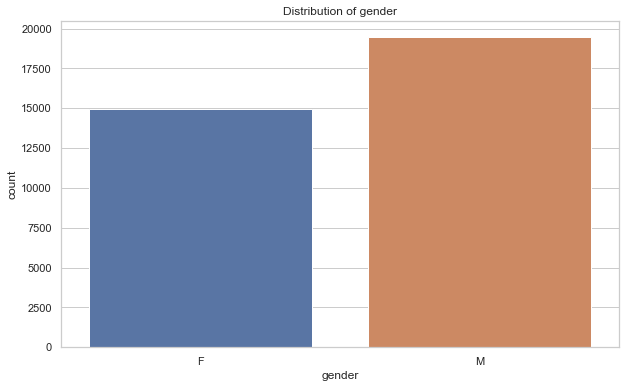

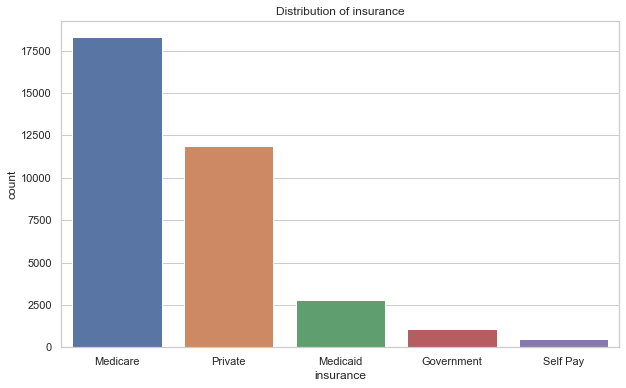

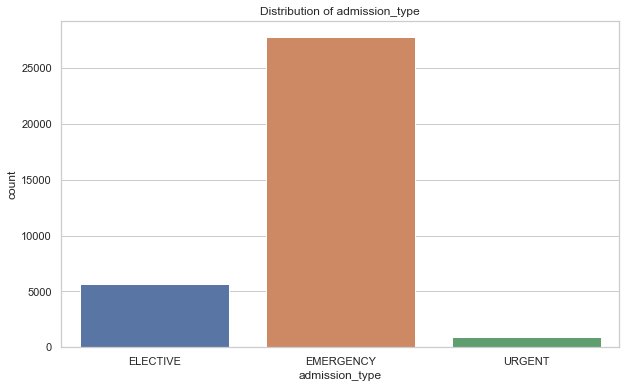

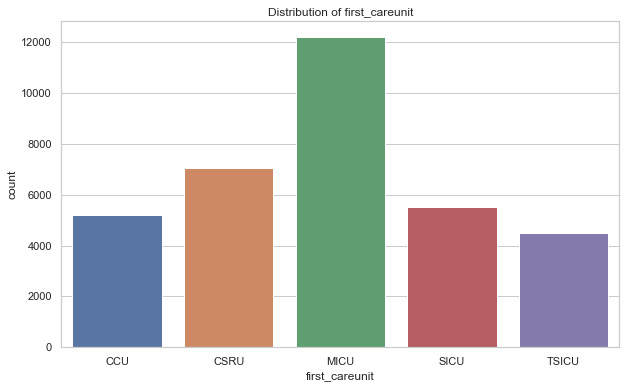

In [9]:
patient_categorical_vars = ["gender", "insurance", "admission_type", "first_careunit"]
plot_categorical_columns(patients, patient_categorical_vars)

<a name='3-1-1-1'></a>
#### Transforming Static Features

In [10]:
# group age
patients['age'] = patients['age'].apply(categorize_age)
patients['age'].value_counts(dropna=False)

>70      14213
51-70    12938
31-50     5489
<31       1832
Name: age, dtype: int64

In [11]:
# check ethnicity categories
patients['ethnicity'].value_counts(dropna=False)

WHITE                                                       24429
UNKNOWN/NOT SPECIFIED                                        3221
BLACK/AFRICAN AMERICAN                                       2456
HISPANIC OR LATINO                                            881
OTHER                                                         785
UNABLE TO OBTAIN                                              652
ASIAN                                                         545
PATIENT DECLINED TO ANSWER                                    351
ASIAN - CHINESE                                               166
HISPANIC/LATINO - PUERTO RICAN                                124
BLACK/CAPE VERDEAN                                            122
WHITE - RUSSIAN                                                99
MULTI RACE ETHNICITY                                           77
BLACK/HAITIAN                                                  64
WHITE - OTHER EUROPEAN                                         59
HISPANIC/L

In [12]:
# Regroup similar categories of ethnicities
patients['ethnicity'] = patients['ethnicity'].apply(categorize_ethnicity)
patients['ethnicity'].value_counts(dropna=False)

WHITE              24675
OTHER/UNKNOWN       5086
BLACK               2667
HISPANIC            1137
ASIAN                865
ISLANDER              25
NATIVE AMERICAN       17
Name: ethnicity, dtype: int64

In [13]:
# regroup admission types into: EMERGENCY & ELECTIVE
patients['admission_type'] = patients['admission_type'].apply(group_admission_type)
patients['admission_type'].value_counts(dropna=False)

EMERGENCY    28767
ELECTIVE      5705
Name: admission_type, dtype: int64

<a name='3-1-2'></a>
`interventions` data

In [14]:
inter_reset = interventions.reset_index()
inter_grouped = interventions.groupby(['hours_in']).sum().reset_index()
inter_grouped.set_index('hours_in', inplace=True)
inter_grouped

,vent,vaso,adenosine,dobutamine,dopamine,epinephrine,isuprel,milrinone,norepinephrine,phenylephrine,vasopressin,colloid_bolus,crystalloid_bolus,nivdurations
hours_in,,,,,,,,,,,,,,
0,3341,1700,2,58,455,73,2,42,386,952,34,27,1280,4903
1,6207,3383,0,103,705,201,3,93,898,1923,65,31,2397,7978
2,8056,4685,2,133,794,362,3,178,1318,2707,109,36,3523,9467
3,9120,5403,2,154,808,499,4,240,1526,3176,153,100,4219,10173
4,9599,5863,2,164,794,606,4,300,1613,3519,197,149,4213,10641
5,9552,5978,2,165,763,649,3,357,1674,3592,227,195,3952,11147
6,9191,6007,0,180,747,672,3,398,1721,3563,253,200,3629,11648
7,8734,5974,2,184,735,687,3,429,1740,3492,281,243,3260,12125
8,8305,5913,1,192,735,676,2,440,1746,3417,306,231,2954,12478


In [15]:
# plot_hourly_counts(df=inter_grouped, features=inter_grouped.columns)

<a name='3-2'></a>
### 3.2 - Continuous Variables

<a name='3-2-1'></a>
`patients` data

In [16]:
# # Calculate length of stay in ICU
# patients['icu_stay_length'] = calculate_duration(patients, 'intime', 'outtime', 'h')  # in hours
#
# # Plot distribution of times
# time_columns = ['admittime', 'dischtime', 'intime', 'outtime']
# plot_time_analysis(patients, time_columns)

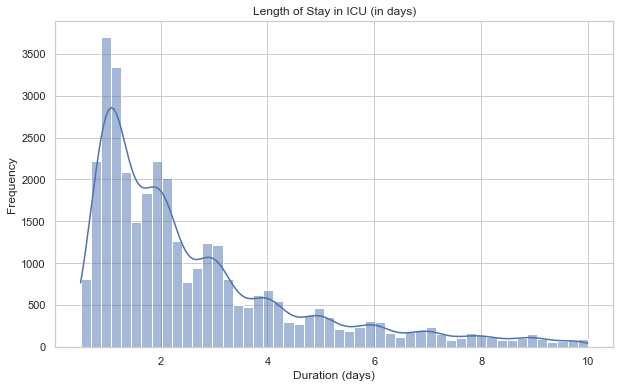

In [17]:
# Plot distribution of length of stay in ICU
plt.figure(figsize=(10,6))
sns.histplot(data=patients, x='los_icu', bins=50, kde=True)
plt.title('Length of Stay in ICU (in days)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

<a name='3-2-2'></a>
`vitals_labs` data
1. **Descriptive Statistics**
We'll start by calculating summary statistics for the DataFrame. This will help us understand the central tendency, spread, and shape of the distribution of the dataset.
<br></br>
2. **Time-Series Plots**
For selected vital signs and lab measurements, we'll plot time-series graphs.
<br></br>
3. **Distribution Plots**
We'll visualize the distribution of selected columns to understand their shape, center, and spread.

In [18]:
vitals_labs_mean.describe()

LEVEL2,alanine aminotransferase,albumin,albumin ascites,albumin pleural,albumin urine,alkaline phosphate,anion gap,asparate aminotransferase,basophils,bicarbonate,...,total protein,total protein urine,troponin-i,troponin-t,venous pvo2,weight,white blood cell count,white blood cell count urine,ph,ph urine
Aggregation Function,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
count,28187.000000,19048.000000,84.000000,81.000000,104.000000,27370.000000,102004.000000,28201.000000,15390.000000,109235.000000,...,271.000000,592.000000,1572.000000,23325.000000,540.000000,39158.000000,104235.000000,3971.000000,124655.000000,17800.000000
mean,254.246624,3.191946,1.729762,1.830864,48.900962,119.145695,14.141292,351.607153,0.402308,23.494447,...,5.804428,151.905405,7.681408,0.813436,44.958333,81.895170,12.196923,22.460766,7.370512,5.810323
std,887.214474,0.694316,0.836484,0.614744,99.112651,143.607969,4.127999,1266.383225,0.510932,4.570154,...,1.129855,316.335636,10.861260,2.162117,15.608904,23.033320,11.223541,71.403553,0.078753,0.928963
min,2.000000,1.000000,0.200000,0.300000,0.400000,20.000000,5.000000,6.000000,0.100000,0.000000,...,3.500000,6.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.100000,6.500000,1.000000
25%,19.000000,2.700000,1.175000,1.400000,3.575000,60.000000,11.500000,25.333333,0.200000,21.000000,...,5.100000,23.000000,0.700000,0.020000,34.000000,66.360564,7.800000,2.000000,7.330000,5.000000
50%,36.000000,3.200000,1.500000,1.900000,10.050000,82.000000,14.000000,49.000000,0.300000,24.000000,...,5.700000,56.000000,2.700000,0.090000,42.000000,79.242587,10.800000,4.000000,7.380000,5.500000
75%,97.000000,3.700000,2.200000,2.300000,41.925000,123.000000,16.000000,137.000000,0.500000,26.000000,...,6.300000,134.500000,10.100000,0.440000,51.000000,94.092170,14.500000,14.000000,7.420000,6.500000
max,10000.000000,6.000000,5.000000,3.400000,589.000000,3625.000000,50.000000,20000.000000,40.000000,53.000000,...,13.200000,3790.000000,49.600000,20.850000,100.000000,250.000000,939.000000,929.000000,8.400000,9.000000


In [19]:
reset_df = vitals_labs.reset_index()
reduced_df = reset_df.groupby(['subject_id', 'hadm_id', 'icustay_id']).mean().reset_index()
reduced_df.drop(columns=['hours_in'], inplace=True)

melted_df = pd.melt(reduced_df, id_vars=['subject_id', 'hadm_id', 'icustay_id'], var_name=['LEVEL2', 'Aggregation Function'], value_name='Value')
melted_df.drop(columns = ['subject_id', 'hadm_id', 'icustay_id'], inplace=True)

vitals_summary = melted_df.groupby(['LEVEL2', 'Aggregation Function']).mean().reset_index()
vitals_summary = vitals_summary.pivot_table(index='LEVEL2', columns='Aggregation Function', values='Value')
vitals_summary.drop(columns=['count'], inplace=True)

vitals_missing = vitals_labs_mean.isnull().sum() / vitals_labs_mean.shape[0] * 100
vitals_missing = vitals_missing.reset_index()
vitals_missing.drop(columns=['Aggregation Function'], inplace=True)
vitals_missing.rename(columns={0: 'missing percent'}, inplace=True)

vitals_pivot = pd.merge(vitals_summary, vitals_missing, on=['LEVEL2'])
vitals_pivot.rename(columns={'LEVEL2': 'measurement'}, inplace=True)
vitals_pivot.sort_values(by='missing percent', ascending=True, inplace=True)
vitals_pivot.reset_index(drop=True, inplace=True)

vitals_ranges_df = pd.read_csv('../resources/vitals_labs_ranges.csv')
vitals_ranges_df.columns = vitals_ranges_df.columns.str.lower()

merged_vitals = pd.merge(vitals_pivot, vitals_ranges_df[['measurement', 'valid low', 'valid high']], on=['measurement'], how='left')
merged_vitals.to_csv('../resources/vitals_labs_stats.csv')
merged_vitals

,measurement,mean,std,missing percent,valid low,valid high
0,heart rate,84.291265,3.914012,9.968537,0.0,350.0
1,respiratory rate,18.414436,3.602833,11.397247,0.0,300.0
2,systolic blood pressure,119.559474,9.476804,12.205239,0.0,375.0
3,diastolic blood pressure,60.592006,6.219356,12.227375,0.0,375.0
4,mean blood pressure,78.276220,7.047384,12.610780,14.0,330.0
...,...,...,...,...,...,...
99,albumin pleural,1.837500,NaN,99.991661,NaN,NaN
100,creatinine ascites,2.187879,NaN,99.996602,NaN,NaN
101,lymphocytes atypical csl,1.685185,1.060660,99.997220,NaN,NaN
102,creatinine pleural,2.269231,NaN,99.997323,NaN,NaN


#### Hourly Measurements Spread across first 30 hours - Vital Signs

In [20]:
# Check at which hours is data most gathered
reset_df = vitals_labs_mean.reset_index()
hourly_vitals_df = reset_df.groupby(['hours_in']).count().reset_index()
hourly_vitals_df.drop(columns=['subject_id', 'hadm_id', 'icustay_id'], inplace=True)
hourly_vitals_df.columns = hourly_vitals_df.columns.droplevel(1)
hourly_vitals_df.set_index('hours_in', inplace=True)
hourly_vitals_df

LEVEL2,alanine aminotransferase,albumin,albumin ascites,albumin pleural,albumin urine,alkaline phosphate,anion gap,asparate aminotransferase,basophils,bicarbonate,...,total protein,total protein urine,troponin-i,troponin-t,venous pvo2,weight,white blood cell count,white blood cell count urine,ph,ph urine
hours_in,,,,,,,,,,,,,,,,,,,,,
0,8297,5847,24,19,23,8080,19605,8288,10133,21935,...,14,119,402,4957,37,8250,22832,1438,16695,9746
1,1821,1356,4,3,7,1776,5243,1824,807,6087,...,14,21,83,1229,51,6753,6488,257,8227,822
2,1449,1070,3,0,3,1425,4692,1450,520,5594,...,13,42,64,1170,43,3876,5653,229,7697,732
3,1174,864,4,2,7,1154,4045,1179,436,4716,...,10,31,79,1038,34,1963,4642,215,7031,662
4,994,743,3,4,5,961,3684,998,297,4114,...,14,33,50,987,28,1203,3966,185,6380,565
5,961,680,1,3,8,925,3520,961,290,3794,...,16,27,45,1035,23,946,3593,173,5962,460
6,965,642,4,3,2,934,3592,965,243,3762,...,16,24,55,1061,16,723,3544,111,5579,403
7,1018,656,2,0,4,979,3727,1016,232,3839,...,12,20,70,1011,15,636,3552,110,5172,352
8,959,636,2,4,2,921,3693,954,208,3776,...,18,23,63,948,18,664,3512,113,4678,301


In [21]:
# plot_hourly_counts(df=hourly_vitals_df, features=VITAL_SIGNS)

#### Hourly Measurements Spread across first 30 hours - Labs

In [22]:
lab_features = list(merged_vitals[merged_vitals['missing percent'] < 95]['measurement'])
lab_features = [feat for feat in lab_features if feat not in VITAL_SIGNS]
lab_features

['glucose',
 'central venous pressure',
 'hematocrit',
 'potassium',
 'sodium',
 'hemoglobin',
 'chloride',
 'partial pressure of carbon dioxide',
 'creatinine',
 'blood urea nitrogen',
 'platelets',
 'bicarbonate',
 'white blood cell count',
 'anion gap',
 'magnesium',
 'partial thromboplastin time',
 'red blood cell count',
 'mean corpuscular hemoglobin concentration',
 'mean corpuscular volume',
 'mean corpuscular hemoglobin',
 'prothrombin time inr',
 'prothrombin time pt',
 'calcium',
 'calcium ionized',
 'phosphate',
 'phosphorous',
 'partial pressure of oxygen']

In [23]:
# plot_hourly_counts(df=hourly_vitals_df, features=lab_features)

<a name='4'></a>
## 4 - Data Pre-processing

<a name='4-1'></a>
### 4.1 - Identifying Missing Data

In the preceding examination, it was identified that missing data exists solely within the `vitals_labs` dataframe.

<a name='4-2'></a>
### 4.2 - Train/Dev/Test Split

When imputing missing values, it's a best practice to calculate the mean (or any other statistic you're using for imputation) from the training set only. Then, use this calculated mean to impute missing values in both the training set and the dev/test sets.
This approach helps in preventing data leakage from the dev/test set into the training set.

The function `train_test_dev_split` performs the data splitting operation for the project. It takes three dataframes (`patients`, `vitals_labs`, and `interventions`) and returns a dictionary containing the train, dev, and test splits for each dataframe.

Steps:
**Filter Targets**: Only consider patients with sufficient data for the target variables `mort_hosp` and `mort_icu`.

**Extract Static Features**: Remove the target variables and other non-static features from the `patients` dataframe.

**Filter Time-Series Data**: Trim the time-series data to only include instances within a specified observation window.

**Subject ID Validation**: Check that the subject IDs are consistent across all dataframes.

**Random Split**: Randomly shuffle the subject IDs and allocate them into train, dev, and test sets based on predefined fractions.

**Dataframe Splits**: Create train, dev, and test dataframes for each of the input dataframes (`patients`, `vitals_labs`, `interventions`), based on the shuffled subject IDs.

**Return Data**: A dictionary containing the train, dev, and test splits for each dataframe is returned.

### Encoding full `patient` categorical data before splitting

In [24]:
# Drop irrelevant or duplicated columns
columns_to_drop = ['admittime', 'dischtime', 'outtime', 'deathtime', 'discharge_location', 'dnr_first_charttime', 'diagnosis_at_admission', 'insurance', 'hospstay_seq', 'hospital_expire_flag', 'los_icu']

patients.drop(columns= columns_to_drop, inplace=True)

# Select columns to be one-hot encoded
categorical_cols = ['gender', 'age', 'ethnicity', 'admission_type', 'first_careunit']

patients_encoded = pd.get_dummies(patients, columns=categorical_cols)
patients_encoded.drop(columns=['gender_F', 'admission_type_ELECTIVE'], inplace=True)
patients_encoded.fillna(0, inplace=True)

patients_encoded.loc[:, 'intime'] = patients_encoded['intime'].astype('datetime64').apply(lambda x : x.hour)

blind_display(patients_encoded, blinded=BLINDED)

patients_encoded.shape:  (34472, 30)


,,,fullcode_first,dnr_first,fullcode,dnr,cmo_first,cmo_last,cmo,intime,mort_icu,mort_hosp,...,ethnicity_ISLANDER,ethnicity_NATIVE AMERICAN,ethnicity_OTHER/UNKNOWN,ethnicity_WHITE,admission_type_EMERGENCY,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
3,145834,211552,1.0,0.0,1.0,1.0,0.0,0.0,0.0,19,0,0,...,0,0,0,1,1,0,0,1,0,0
4,185777,294638,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
6,107064,228232,1.0,0.0,1.0,0.0,0.0,0.0,0.0,21,0,0,...,0,0,0,1,0,0,0,0,1,0
9,150750,220597,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13,1,1,...,0,0,1,0,1,0,0,1,0,0
11,194540,229441,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6,0,0,...,0,0,0,1,1,0,0,0,1,0


In [25]:
datasets = train_test_dev_split(patients_encoded, vitals_labs, interventions)

In [26]:
# Define keys and corresponding variable names
keys_varnames = [
    ('patients', 'patients_train', 'patients_dev', 'patients_test'),
    ('vitals', 'vitals_train', 'vitals_dev', 'vitals_test'),
    ('interv', 'interv_train', 'interv_dev', 'interv_test'),
    ('Ys', 'Ys_train', 'Ys_dev', 'Ys_test')
]

# Loop through each key and variable name to extract data and print shapes
for key, train_var, dev_var, test_var in keys_varnames:
    train_data, dev_data, test_data = datasets[key]
    print(f'\n{key.capitalize()}:')
    print(train_data.shape)
    print(dev_data.shape)
    print(test_data.shape)

    # log the datasets
    save_to_pickle(train_data, os.path.join(LOG_DATA_DIR, f'{train_var}_gru_split.pkl'))
    save_to_pickle(dev_data, os.path.join(LOG_DATA_DIR, f'{dev_var}_gru_split.pkl'))
    save_to_pickle(test_data, os.path.join(LOG_DATA_DIR, f'{test_var}_gru_split.pkl'))

    # set the variables
    globals()[train_var], globals()[dev_var], globals()[test_var] = train_data, dev_data, test_data


Patients:
(16760, 27)
(2395, 27)
(4789, 27)

Vitals:
(402240, 312)
(57480, 312)
(114936, 312)

Interv:
(402240, 14)
(57480, 14)
(114936, 14)

Ys:
(16760, 2)
(2395, 2)
(4789, 2)


<a name='4-3'></a>
### 4.3 Data Imputation
The strategy for handling the missing values in `vitals_labs` is as follows:

- Initial imputation employs **forward-filling** to propagate the last valid observation to succeeding `NaN` entries.

- Subsequently, any residual missing values within each `icustay_id` group are replaced by the **group's mean**.

- Finally, any remaining `NaN`s are filled with **zeros**.

- A binary mask is generated to indicate the presence of data.

- Time deltas are computed to represent the duration since the last available measurement for each column.

#### Simple Impute

In [27]:
%%time
global_means, icustay_means = calculate_impute_values(vitals_train)

vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed = [
    simple_imputer(df, global_means, icustay_means) for df in (vitals_train, vitals_dev, vitals_test)
]
# vitals_train_flat, vitals_dev_flat, vitals_test_flat = [
#     df.pivot_table(index=['subject_id', 'hadm_id', 'icustay_id'], columns=['hours_in']) for df in (
#         vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed
#     )
# ]

# log the datasets
save_to_pickle(vitals_train_imputed, os.path.join(LOG_DATA_DIR, f'vitals_train_gru_imputed.pkl'))
save_to_pickle(vitals_dev_imputed, os.path.join(LOG_DATA_DIR, f'vitals_dev_gru_imputed.pkl'))
save_to_pickle(vitals_test_imputed, os.path.join(LOG_DATA_DIR, f'vitals_test_gru_imputed.pkl'))

for df in vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed: assert not df.isnull().any().any()

Wall time: 6min 7s


In [28]:
# vitals_train_imputed = load_from_pickle(os.path.join(DATA_DIR, 'vitals_train.pkl'))
# vitals_dev_imputed = load_from_pickle(os.path.join(DATA_DIR, 'vitals_dev.pkl'))
# vitals_test_imputed = load_from_pickle(os.path.join(DATA_DIR, 'vitals_test.pkl'))

#### Hybrid Impute

In [29]:
# %%time
# global_means, icustay_means = calculate_impute_values(vitals_train)
#
# vitals_train_imputed2, vitals_dev_imputed2, vitals_test_imputed2 = [
#     hybrid_imputer(df, global_means, icustay_means) for df in (vitals_train, vitals_dev, vitals_test)
# ]
# for df in vitals_train_imputed2, vitals_dev_imputed2, vitals_test_imputed2: assert not df.isnull().any().any()

In [30]:
# # Define keys and corresponding variable names
# vitals_train_imputed2.to_csv('../data/processed_hybrid/vitals_train_hybrid.csv')
# vitals_dev_imputed2.to_csv('../data/processed_hybrid/vitals_dev_hybrid.csv')
# vitals_test_imputed2.to_csv('../data/processed_hybrid/vitals_test_hybrid.csv')

#### Data Standardization

In [31]:
def standardize_gru(vitals_train, vitals_dev, vitals_test):
    idx = pd.IndexSlice
    X_train, X_dev, X_test = vitals_train.copy(), vitals_dev.copy(), vitals_test.copy()

    # Min-Max Scaling
    train_min = X_train.loc[:, idx[:, 'mean']].min()
    train_max = X_train.loc[:, idx[:, 'mean']].max()
    for df in [X_train, X_dev, X_test]:
        df.loc[:, idx[:, 'mean']] = minmax_scaling(df.loc[:, idx[:, 'mean']], train_min, train_max)

    # Standardization
    X_train.loc[:, idx[:, 'time_since_measured']] = np.where(X_train.loc[:, idx[:, 'time_since_measured']] == 100, 0,
                                                             X_train.loc[:, idx[:, 'time_since_measured']])
    train_mean = X_train.loc[:, idx[:, 'time_since_measured']].mean()
    train_std = X_train.loc[:, idx[:, 'time_since_measured']].std()
    for df in [X_train, X_dev, X_test]:
        df.loc[:, idx[:, 'time_since_measured']] = standardize_time_since_measured(
            df.loc[:, idx[:, 'time_since_measured']], train_mean, train_std)

    return X_train, X_dev, X_test

In [32]:
vitals_train_std, vitals_dev_std, vitals_test_std = standardize_gru(vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed)

In [33]:
# log the datasets
save_to_pickle(vitals_train_std, os.path.join(LOG_DATA_DIR, f'vitals_train_gru_std.pkl'))
save_to_pickle(vitals_dev_std, os.path.join(LOG_DATA_DIR, f'vitals_dev_gru_std.pkl'))
save_to_pickle(vitals_test_std, os.path.join(LOG_DATA_DIR, f'vitals_test_gru_std.pkl'))

In [34]:
highly_corr_drop = ['dnr', 'fullcode', 'cmo', 'cmo_last']
patients_train.drop(columns=highly_corr_drop, inplace=True)
patients_dev.drop(columns=highly_corr_drop, inplace=True)
patients_test.drop(columns=highly_corr_drop, inplace=True)

In [35]:
vitals_to_drop = ['alanine aminotransferase', 'co2', 'co2 (etco2, pco2, etc.)', 'blood urea nitrogen', 'cardiac output thermodilution', 'chloride', 'cholesterol ldl', 'hematocrit', 'red blood cell count', 'lactic acid', 'mean corpuscular volume', 'phosphorous', 'positive end-expiratory pressure', 'potassium serum', 'prothrombin time pt', 'tidal volume set']

In [38]:
vitals_train_std.drop(columns=vitals_to_drop, level=0, inplace=True)
vitals_dev_std.drop(columns=vitals_to_drop, level=0, inplace=True)
vitals_test_std.drop(columns=vitals_to_drop, level=0, inplace=True)

### Create Feature Matrix

In [75]:
# X_train_merged = create_feature_matrix(patients_train, vitals_train_std, interv_train)
# X_dev_merged = create_feature_matrix(patients_dev, vitals_dev_std, interv_dev)
# X_test_merged = create_feature_matrix(patients_test, vitals_test_std, interv_test)
# blind_display(X_train_merged, X_dev_merged, X_test_merged, blinded=BLINDED)

### Store Processed Data

In [76]:
save_to_pickle(df=vitals_train_std, filename=os.path.join(DATA_DIR, 'Vitals_train_gru.pkl'))
save_to_pickle(df=vitals_dev_std, filename=os.path.join(DATA_DIR, 'Vitals_dev_gru.pkl'))
save_to_pickle(df=vitals_test_std, filename=os.path.join(DATA_DIR, 'Vitals_test_gru.pkl'))

# save_to_pickle(df=Ys_train, filename=os.path.join(DATA_DIR, 'Y_train_gru.pkl'))
# save_to_pickle(df=Ys_dev, filename=os.path.join(DATA_DIR, 'Y_dev_gru.pkl'))
# save_to_pickle(df=Ys_test, filename=os.path.join(DATA_DIR, 'Y_test_gru.pkl'))